In [1]:
#
# Finance environment
#
# @ Dr. Yves J. Hippisch
#
#
import math
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
class observation_space:
    def __init__(self,n):
        self.shape = (n,)

In [3]:
class action_space:
    def __init__(self,n):
        self.n = n
    
    def sample(self):
        return random.randint(0, self.n - 1)

In [4]:
class Finance:
    intraday = False
    #time_increment = '30min'
    if intraday:
        url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
    else:
        url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    
    def __init__(self, symbol, features, window, lags,
                leverage = 1, min_performance = 0.85, min_accuracy = 0.5,
                start = 0, end=None, mu=None, std=None, time_increment='30min'):
        self.symbol = symbol
        self.features = features # features which define the state
        self.n_features = len(features) # number of features 
        self.window = window
        self.lags = lags # number of lags
        self.leverage = leverage
        self.min_performance = min_performance # minimum (gross) perf required 
        self.min_accuracy = min_accuracy
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data(time_increment)
        self._prepare_data()
        
    def _get_data(self, _increment):
        self.raw = pd.read_csv(self.url, index_col=0, parse_dates=True).dropna()
        
        if self.intraday:
            self.raw = self.raw = self.raw.resample(_increment, label='right').last()
            self.raw = pd.DataFrame(self.raw['Close'])
            self.raw.columns = [self.symbol]
    
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1)) # returns
        self.data.dropna(inplace = True)
        self.data['s'] = self.data[self.symbol].rolling(self.window).mean() # SMA
        self.data['m'] = self.data['r'].rolling(self.window).mean() # Momentum
        self.data['v'] = self.data['r'].rolling(self.window).std()  # Variance/volatility
        self.data.dropna(inplace=True)
        if self.mu is None:
            # compute mean and variance 
            self.mu = self.data.mean()
            self.std = self.data.std()
        # Perform Gaussian normalization of the data 
        self.data_ = (self.data - self.mu) / self.std 
        # where returns are positive, set to 1, else set to 0.
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
            
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar - self.lags:self.bar]
    
    def get_state(self,bar):
        return self.data_[self.features].iloc[bar - self.lags:bar]
    
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar -
                                               self.lags:self.bar]
        
        return state.values
    
    def step(self, action, patience):
        """Takes a step in the environment."""
        correct = action == self.data_['d'].iloc[self.bar] # check whether agent has made the right action
        ret = self.data['r'].iloc[self.bar] * self.leverage # leveraged return
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret) # return based reward
        self.treward += reward_1
        self.bar += 1 # increments the environment forwards
        self.accuracy = self.treward / (self.bar - self.lags) # cumulative accuracy of all trades
        self.performance *= math.exp(reward_2) # gross performance after the step
        
        # set stopping conditions
        if self.bar >= len(self.data):
            done = True # end if agent reaches end of dataset. Considered a success.
        elif reward_1 == 1:
            # continues so long as we make a good trade
            done =False
        elif (self.performance < self.min_performance and
             self.bar > self.lags + patience):
            # ends if performance drops below the min after number of steps (patience)
            done =True 
        else:
            done = False
            
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 5, done, info

In [5]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [6]:
env = Finance(symbol, features, window=20, lags=3,
                 leverage=1, min_performance=0.9, min_accuracy=0.475,
                 start=0, end=1750, mu=None, std=None)

In [7]:
a = env.action_space.sample()

In [8]:
a

0

In [9]:
env.reset()

array([[ 1.48374577,  0.44804946,  1.71328353, -1.22291926,  0.04266759],
       [ 1.42769847, -0.78703266,  1.69231155, -1.28602745,  0.05929161],
       [ 1.28179756, -2.09069751,  1.66205835, -1.89996815,  0.23332602]])

In [10]:
env.step(a, patience=15)

(array([[ 1.42769847, -0.78703266,  1.69231155, -1.28602745,  0.05929161],
        [ 1.28179756, -2.09069751,  1.66205835, -1.89996815,  0.23332602],
        [ 1.21774351, -0.91716949,  1.63278682, -1.8470198 ,  0.21158283]]),
 1.0262812694441348,
 False,
 {})

In [11]:
env.data

,EUR=,r,s,m,v
Date,,,,,
2010-02-02,1.3961,0.002438,1.422445,-0.001586,0.005403
2010-02-03,1.3898,-0.004523,1.420095,-0.001663,0.005435
2010-02-04,1.3734,-0.011870,1.416705,-0.002409,0.005767
2010-02-05,1.3662,-0.005256,1.413425,-0.002345,0.005726
2010-02-08,1.3652,-0.000732,1.409625,-0.002709,0.005350
...,...,...,...,...,...
2017-01-06,1.0530,-0.006909,1.049070,-0.001039,0.006922
2017-01-09,1.0572,0.003981,1.048855,-0.000203,0.006427
2017-01-10,1.0553,-0.001799,1.048825,-0.000028,0.006328


In [24]:
#
#
# Trading Bot - Financial Q-learning Agent
#
# @ Dr. Yves J. Hippisch
#
#
import os
import random
import numpy as np
from pylab import plt, mpl
from collections import deque
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop

In [25]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [26]:
os.environ['PYTHONHASHSEED'] = '0' 
#plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [27]:
def set_seeds(seed=100):
    ''' Sets seeds for all random number generators'''
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [28]:
class TradingBot:
    def __init__(self, hidden_units, learning_rate, learn_env,
                 valid_env=None, val=True, dropout=False):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.val = val
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.learning_rate = learning_rate
        self.gamma = 0.5
        self.batch_size = 128
        self.max_treward = 0
        self.averages = list()
        self.trewards = []
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units,
                             learning_rate, dropout)

    def _build_model(self, hu, lr, dropout):
        ''' Method to create the DNN model.
        '''
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
            activation='relu'))
        if dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=RMSprop(learning_rate=lr)
        )
        return model

    def act(self, state):
        ''' Method for taking action based on
            a) exploration
            b) exploitation
        '''
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)

    def replay(self):
        ''' Method to retrain the DNN model based on
            batches of memorized experiences.
        '''
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        ''' Method to train the DQL agent.
        '''
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = self.learn_env.step(action, patience =15)
                next_state = np.reshape(next_state,
                                        [1, self.learn_env.lags,
                                         self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                    next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                       av, self.max_treward), end='\r')
                    break
            if self.val:
                self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def validate(self, e, episodes):
        ''' Method to validate the performance of the
            DQL agent.
        '''
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action, patience =15)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                            self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % int(episodes / 6) == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break



    def plot_treward(agent):
        ''' Function to plot the total reward
            per training eposiode.
        '''
        plt.figure(figsize=(10, 6))
        x = range(1, len(agent.averages) + 1)
        y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
        plt.plot(x, agent.averages, label='moving average')
        plt.plot(x, y, 'r--', label='regression')
        plt.xlabel('episodes')
        plt.ylabel('total reward')
        plt.legend()


    def plot_performance(agent):
        ''' Function to plot the financial gross
            performance per training episode.
        '''
        plt.figure(figsize=(10, 6))
        x = range(1, len(agent.performances) + 1)
        y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
        plt.plot(x, agent.performances[:], label='training')
        plt.plot(x, y, 'r--', label='regression (train)')
        if agent.val:
            y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
            plt.plot(x, agent.vperformances[:], label='validation')
            plt.plot(x, y_, 'r-.', label='regression (valid)')
        plt.xlabel('episodes')
        plt.ylabel('gross performance')
        plt.legend()


In [29]:
symbol = 'EUR='
features = [symbol, 'r','s','m','v']

In [30]:
a = 0
b= 1750
c =250

In [31]:
learn_env = Finance(symbol, features, window =20, 
                    lags=3, leverage =1, min_performance=0.9, 
                    min_accuracy=0.475, start=a, end = a + b, 
                    mu =None, std=None)

In [32]:
valid_env = Finance(symbol, features=learn_env.features, 
                    window =learn_env.window, 
                    lags=learn_env.lags, 
                    leverage =learn_env.leverage, 
                    min_performance=0.0, min_accuracy=0.0, start=a+b, end = a+b+c, 
                    mu =learn_env.mu, std=learn_env.std)


In [33]:
set_seeds(100)
agent=TradingBot(24, learning_rate=0.001, learn_env=learn_env, valid_env=valid_env)

In [34]:
episodes = 61

In [35]:
%time agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 0.930 | eps: 0.91
episode: 20/61 | VALIDATION | treward:  247 | perf: 0.938 | eps: 0.83
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.924 | eps: 0.75
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.944 | eps: 0.68
episode: 50/61 | VALIDATION | treward:  247 | perf: 1.011 | eps: 0.61
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.891 | eps: 0.55
episode: 61/61 | treward:  606 | perf: 0.899 | av: 1288.7 | max: 1747
CPU times: user 4min 31s, sys: 12 s, total: 4min 43s
Wall time: 4min 17s


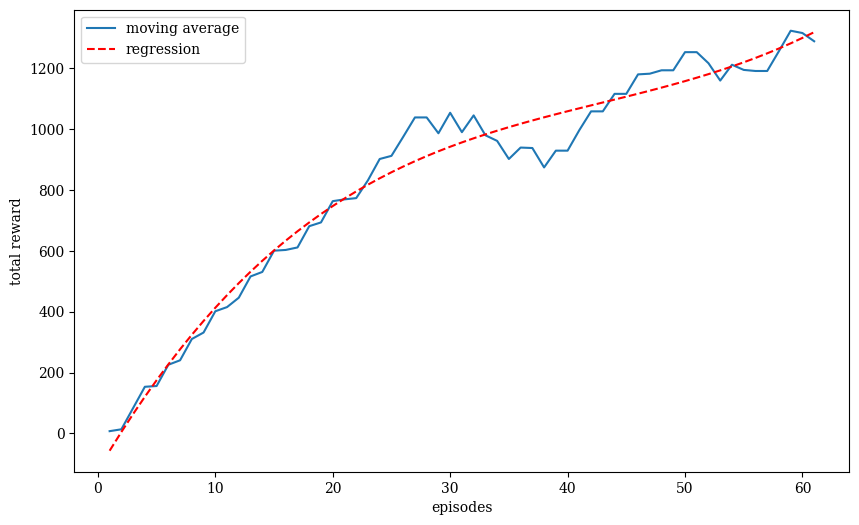

In [36]:
TradingBot.plot_treward(agent)

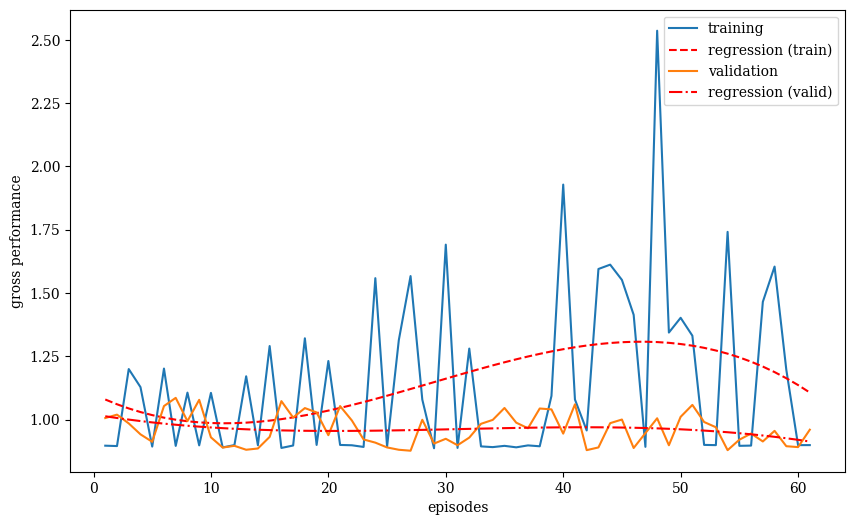

In [37]:
TradingBot.plot_performance(agent)

In [38]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [39]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0])
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action,patience=15)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [40]:
env = agent.learn_env

In [41]:
backtest(agent, env)

check the number of long (1) and short (-1) positions taken during the backtest

In [42]:
env.data['p'].iloc[env.lags:].value_counts()

p
 1    898
-1    849
Name: count, dtype: int64

In [43]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   -0.227465
s    0.488483
dtype: float64

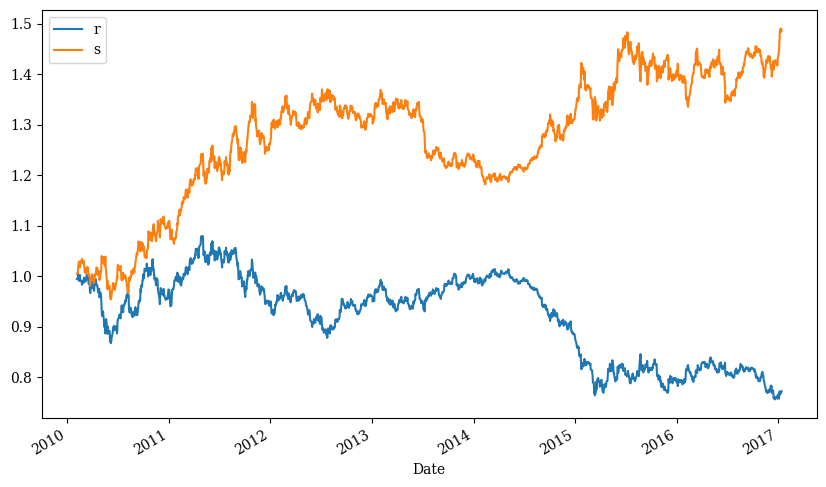

In [44]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

Now we need to check performacne out of the training sample. Initialize a finance environment on unseen data.

In [45]:
test_env = Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [46]:
env = test_env

In [47]:
backtest(agent, env)

Trade (short vs long) position counts

In [48]:
env.data['p'].iloc[env.lags:].value_counts()

p
-1    334
 1    159
Name: count, dtype: int64

Total net return/SMA

In [49]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)-1

r   -0.085570
s   -0.027456
dtype: float64

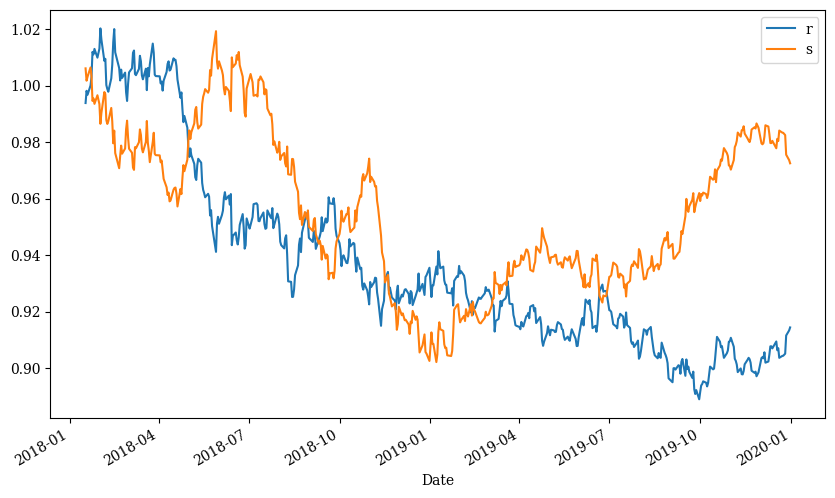

In [50]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

##  Proceed to event based backtesting

In [95]:
#
# Event based backtesting class
# -- Base class 
#
# 

class BacktestingBase:
    def __init__(self, env, model, amount, ptc, ftc, verbose=False):
        self.env = env
        self.model = model
        self.initial_amount = amount
        self.current_balance = amount
        self.ptc = ptc
        self.ftc = ftc
        self.verbose = verbose
        self.units = 0
        self.trades = 0

    def get_date_price(self, bar):
        ''' Returns date and price for a given bar.
        '''
        date = str(self.env.data.index[bar])[:10]
        price = self.env.data[self.env.symbol].iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Prints the current cash balance for a given bar.
        '''
        date, price = self.get_date_price(bar)
        #print(f'{date} | current balance = {self.current_balance:.2f}')

    def calculate_net_wealth(self, price):
        return self.current_balance + self.units * price

    def print_net_wealth(self, bar):
        ''' Prints the net wealth for a given bar
            (cash + position).
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.calculate_net_wealth(price)
       # print(f'{date} | net wealth = {net_wealth:.2f}')

    def place_buy_order(self, bar, amount=None, units=None):
        ''' Places a buy order for a given bar and quantity of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # alternative handling
        self.current_balance -= (1 + self.ptc) * \
            units * price + self.ftc
        self.units += units
        self.trades += 1
        #if self.verbose:
         #   print(f'{date} | buy {units} units for {price:.4f}')
          #  self.print_balance(bar)

    def place_sell_order(self, bar, amount=None, units=None):
        ''' Places a sell order for a given bar and quantity of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # altermative handling
        self.current_balance += (1 - self.ptc) * \
            units * price - self.ftc
        self.units -= units
        self.trades += 1
        #if self.verbose:
            #print(f'{date} | sell {units} units for {price:.4f}')
       #     self.print_balance(bar)

    def close_out(self, bar):
        ''' Closes out any open position at a given bar.
        '''
        date, price = self.get_date_price(bar)
        #print(50 * '=')
       # print(f'{date} | *** CLOSING OUT ***')
        if self.units < 0:
            self.place_buy_order(bar, units= -self.units)
        else:
            self.place_sell_order(bar, units=self.units)
        #if not self.verbose:
        #    print(f'{date} | current balance = {self.current_balance:.2f}')
        perf = (self.current_balance / self.initial_amount - 1) * 100
       # print(f'{date} | net performance [%] = {perf:.4f}')
        #print(f'{date} | number of trades [#] = {self.trades}')
       # print(50 * '=')

        

In [96]:
class BacktestingBaseRM(BacktestingBase):

    def set_prices(self, price):
        ''' Sets prices for tracking of performance.
            To test for e.g. trailing stop loss hit.
        '''
        self.entry_price = price
        self.min_price = price
        self.max_price = price

    def place_buy_order(self, bar, amount=None, units=None, gprice=None):
        ''' Places a buy order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if gprice is not None:
            price = gprice
        if units is None:
            units = int(amount / price)
        self.current_balance -= (1 + self.ptc) * units * price + self.ftc
        self.units += units
        self.trades += 1
        self.set_prices(price)
        #if self.verbose:
           # print(f'{date} | buy {units} units for {price:.4f}')
          #  self.print_balance(bar)

    def place_sell_order(self, bar, amount=None, units=None, gprice=None):
        ''' Places a sell order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if gprice is not None:
            price = gprice
        if units is None:
            units = int(amount / price)
        self.current_balance += (1 - self.ptc) * units * price - self.ftc
        self.units -= units
        self.trades += 1
        self.set_prices(price)
        #if self.verbose:
            #print(f'{date} | sell {units} units for {price:.4f}')
            #self.print_balance(bar)



In [97]:
class TBBacktesterRM(BacktestingBaseRM):
    def _reshape(self, state):
        ''' Helper method to reshape state objects.
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])

    def backtest_strategy(self, sl=None, tsl=None, tp=None,
                          wait=5, guarantee=False):
        ''' Event-based backtesting of the trading bot's performance.
            Incl. stop loss, trailing stop loss and take profit.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.sl = sl
        self.tsl = tsl
        self.tp = tp
        self.wait = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            self.wait = max(0, self.wait - 1)
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                #print(50 * '=')
                #print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                #print(50 * '=')

            # stop loss order
            if sl is not None and self.position != 0:
                rc = (price - self.entry_price) / self.entry_price
                if self.position == 1 and rc < -self.sl:
                    #print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 - self.sl)
                        #print(f'*** STOP LOSS (LONG  | {-self.sl:.4f}) ***')
                    else:
                        pass
                        #print(f'*** STOP LOSS (LONG  | {rc:.4f}) ***')
                    self.place_sell_order(bar, units=self.units, gprice=price)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc > self.sl:
                    #print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 + self.sl)
                        #print(f'*** STOP LOSS (SHORT | -{self.sl:.4f}) ***')
                    else:
                        pass
                        #print(f'*** STOP LOSS (SHORT | -{rc:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units, gprice=price)
                    self.wait = wait
                    self.position = 0

            # trailing stop loss order
            if tsl is not None and self.position != 0:
                self.max_price = max(self.max_price, price)
                self.min_price = min(self.min_price, price)
                rc_1 = (price - self.max_price) / self.entry_price
                rc_2 = (self.min_price - price) / self.entry_price
                if self.position == 1 and rc_1 < -self.tsl:
                    #print(50 * '-')
                    #print(f'*** TRAILING SL (LONG  | {rc_1:.4f}) ***')
                    self.place_sell_order(bar, units=self.units)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc_2 < -self.tsl:
                    #print(50 * '-')
                    #print(f'*** TRAILING SL (SHORT | {rc_2:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units)
                    self.wait = wait
                    self.position = 0

            # take profit order
            if tp is not None and self.position != 0:
                rc = (price - self.entry_price) / self.entry_price
                if self.position == 1 and rc > self.tp:
                    #print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 + self.tp)
                        #print(f'*** TAKE PROFIT (LONG  | {self.tp:.4f}) ***')
                    else:
                        pass
                        #print(f'*** TAKE PROFIT (LONG  | {rc:.4f}) ***')
                    self.place_sell_order(bar, units=self.units, gprice=price)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc < -self.tp:
                    #print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 - self.tp)
                        #print(f'*** TAKE PROFIT (SHORT | {self.tp:.4f}) ***')
                    else:
                        pass
                        #print(f'*** TAKE PROFIT (SHORT | {-rc:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units, gprice=price)
                    self.wait = wait
                    self.position = 0

            state = self.env.get_state(bar)
            action = np.argmax(self.model.predict(
                self._reshape(state.values))[0, 0])
            position = 1 if action == 1 else -1
            if self.position in [0, -1] and position == 1 and self.wait == 0:
                #if self.verbose:
                    
                    #print(50 * '-')
                    #print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1 and self.wait == 0:
                #if self.verbose:
                    #print(50 * '-')
                    #print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append((date, self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths,
                                        columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(self.net_wealths.index)
        self.close_out(bar)
      

In [54]:
test_env = Finance(symbol, features = learn_env.features, window = learn_env.window, 
                   lags = learn_env.lags, leverage=learn_env.leverage,
                  min_performance=0.0, min_accuracy=0.0, start = a+b+c, end=None,
                   mu = learn_env.mu, std =learn_env.std)

In [55]:
env = learn_env

In [56]:
tb = TBBacktesterRM(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [57]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 14407.83
2017-01-12 | net performance [%] = 44.0783
2017-01-12 | number of trades [#] = 896


The above does not take into account *transaction costs* for buying / selling. Adding a typical $0.015$% transaction cost and backtesting again on the learning environment...

In [58]:
tb_tc = TBBacktesterRM(env, agent.model, 10000,
                   0.00015, 0.0, verbose=False)

In [59]:
tb_tc.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 12597.53
2017-01-12 | net performance [%] = 25.9753
2017-01-12 | number of trades [#] = 896


With transaxtion costs, we have a lower net performance, though it's still good on the learning environment. Looking at the fluctation of net wealth...

<Axes: xlabel='date'>

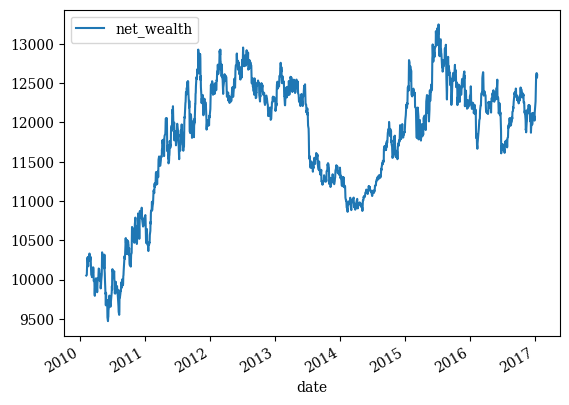

In [60]:
tb_tc.net_wealths.plot()

Now with the backtest sans transaction costs on the same plot:

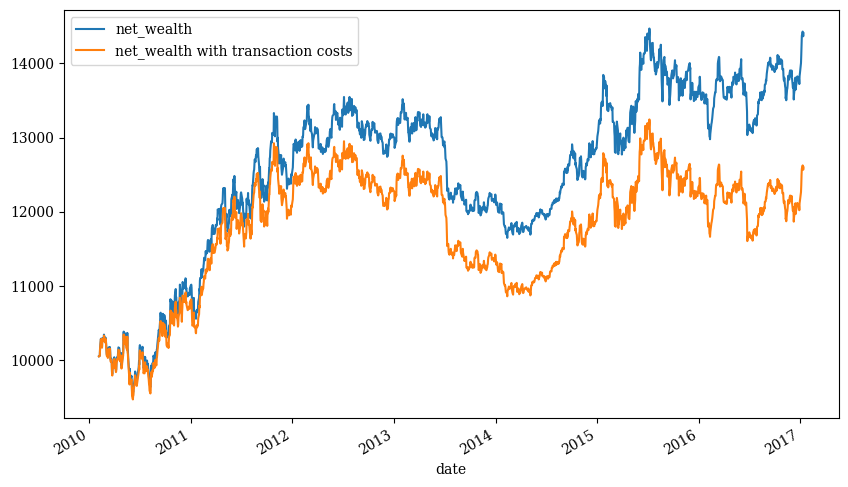

In [61]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_tc.net_wealths.columns = ['net_wealth with transaction costs']
tb_tc.net_wealths.plot(ax=ax);

That transaction costs would lower the net gain is fairly trivial. It's semi-interesting that the same number of trades are made in both cases, though perhaps the Finance learning environment needs to take the TC's into account more directly. 

For the test environment:

In [62]:
env = test_env

In [63]:
tb = TBBacktesterRM(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [64]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9681.51
2019-12-31 | net performance [%] = -3.1849
2019-12-31 | number of trades [#] = 322


In [65]:
tb_TC = TBBacktesterRM(env, agent.model, 10000,
                  0.00015, 0, verbose=False)

In [66]:
tb_TC.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9225.01
2019-12-31 | net performance [%] = -7.7499
2019-12-31 | number of trades [#] = 322


Similar results

## Incorporate some standard risk management indicators

In [67]:
data = pd.DataFrame(learn_env.data[symbol])

In [68]:
data.head()

,EUR=
Date,
2010-02-02,1.3961
2010-02-03,1.3898
2010-02-04,1.3734
2010-02-05,1.3662
2010-02-08,1.3652


Compute the *average true range (ATR)* which we will relate our other risk management measures to.

In [69]:
window = 20

In [70]:
data['min'] = data[symbol].rolling(window).min()

In [71]:
data['max'] = data[symbol].rolling(window).max()

In [72]:
data['mami'] = data['max'] - data['min']

In [73]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [74]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [75]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [76]:
data['atr'] = np.maximum(data['atr'], data['mic'])

In [77]:
data['atr%'] = data['atr'] / data[symbol]

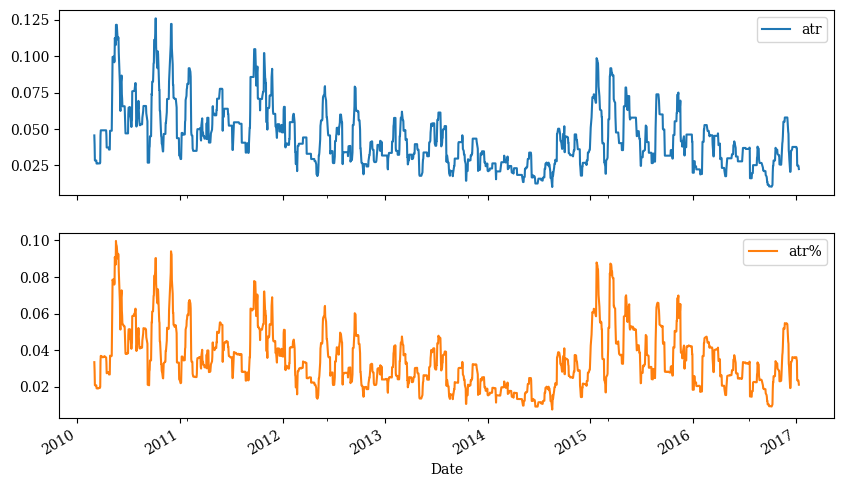

In [78]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));

In [79]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,0.0249,0.023647
2017-01-09,0.0249,0.023553
2017-01-10,0.0249,0.023595
2017-01-11,0.0240,0.022684
2017-01-12,0.0225,0.021206


Adding leverage: we will see atr go up - > larger range of possible fluctuations.

In [80]:
leverage = 10

In [81]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,0.249,0.236467
2017-01-09,0.249,0.235528
2017-01-10,0.249,0.235952
2017-01-11,0.240,0.226843
2017-01-12,0.225,0.212064


In [82]:
data[['atr', 'atr%']].median() * leverage

atr     0.39900
atr%    0.32141
dtype: float64

## Use risk measure options in tbbacktestingRM class to test risk management metrics.

In [134]:
env = test_env

In [192]:
test_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2018-01-11 to 2019-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    496 non-null    float64
 1   r       496 non-null    float64
 2   s       496 non-null    float64
 3   m       496 non-null    float64
 4   v       496 non-null    float64
dtypes: float64(5)
memory usage: 23.2 KB


In [135]:
tb = TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)

In [136]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5) # no RM

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9681.51
2019-12-31 | net performance [%] = -3.1849
2019-12-31 | number of trades [#] = 322


### Add stop loss

In [137]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0202) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0187) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0181) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9788.53
2019-12-31 | net performance [%] = -2.1147
2019-12-31 | number of trades [#] = 316


In [144]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0170) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0170) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9814.99
2019-12-31 | net performance [%] = -1.8501
2019-12-31 | number of trades [#] = 312


Improvement over the test without SL

### Add Trailing Stop Loss

In [145]:
tb.backtest_strategy(sl=None, tsl=0.015,
                     tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0202) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0174) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0170) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0191) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0160) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0172) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0181) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0175) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0155) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9592.01
2019-12-31 | net performance [%] = -4.0799
2019-12-

Seems worse

### Add Take Profit

In [146]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0151) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0213) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0176) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0160) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9681.59
2019-12-31 | net performance [%] = -3.1841
2019-12-31 | number of trades [#] = 328


In [147]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0150) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9587.50
2019-12-31 | net performance [%] = -4.1250
2019-12-31 | number of trades [#] = 328


Does a little worse. Not all the risk measures beat the RM-less version.

## Combinations

In [167]:
tb.backtest_strategy(sl=0.015, tsl=None,
                     tp=0.015, wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0050) ***
--------------------------------------------

In [151]:
tb.backtest_strategy(sl=None, tsl=0.02,
                     tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0202) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0238) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0227) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0222) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0209) ***
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 9655.11
2019-12-31 | net performance [%] = -3.4489
2019-12-31 | number of trades [#] = 316


Some parameter benchmarking:

In [99]:
tb = TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)

In [100]:
incrs = [None, 0.0005,0.005,0.010,0.015, 0.02]
outs = {}
for inc in incrs:
    for inc2 in incrs:
        tb.backtest_strategy(sl=inc, tsl=None, tp=inc2, wait=5)
        profit=(tb.current_balance / tb.initial_amount - 1) * 100
        print(f"^^^With stop loss = {inc} and take profit = {inc2}, profit is {profit}")
        #print(50*'-')
        print('NEXT')
        print(50*'=')
        outs[f'SL={inc},TP={inc2}'] = profit
print(outs)

^^^With stop loss = None and take profit = None, profit is -3.1848680000001184
NEXT
^^^With stop loss = None and take profit = 0.0005, profit is 7.631068000000196
NEXT
^^^With stop loss = None and take profit = 0.005, profit is 19.57206900000019
NEXT
^^^With stop loss = None and take profit = 0.01, profit is 2.566949000000074
NEXT
^^^With stop loss = None and take profit = 0.015, profit is -3.184062000000032
NEXT
^^^With stop loss = None and take profit = 0.02, profit is -3.6444489999999163
NEXT
^^^With stop loss = 0.0005 and take profit = None, profit is -13.365309999999663
NEXT
^^^With stop loss = 0.0005 and take profit = 0.0005, profit is -3.1222490000000325
NEXT
^^^With stop loss = 0.0005 and take profit = 0.005, profit is -1.3483270000002268
NEXT
^^^With stop loss = 0.0005 and take profit = 0.01, profit is -8.509812999999887
NEXT
^^^With stop loss = 0.0005 and take profit = 0.015, profit is -12.20558499999964
NEXT
^^^With stop loss = 0.0005 and take profit = 0.02, profit is -11.82

In [101]:
max(outs, key=outs.get)

'SL=0.015,TP=0.005'

In [102]:
outs['SL=0.015,TP=0.005']

20.318404999999927

Best results:
stop loss = 0.015
take profit = 0.005
achieving ~20.3 % net performance
Appears that take profit cannot be too high (more than ~0.01) and that stop loss cannot be too low or too high (between ~0.01 and ~0.02 seems right) otherwise we have net losses.

In [103]:
# Same thing but with tsl instead of sl
incrs = [None, 0.0005,0.005,0.010,0.015, 0.02]
outs = {}
for inc in incrs:
    for inc2 in incrs:
        tb.backtest_strategy(sl=None, tsl=inc, tp=inc2, wait=5)
        profit=(tb.current_balance / tb.initial_amount - 1) * 100
        print(f"^^^With trailing stop loss = {inc} and take profit = {inc2}, profit is {profit}")
        #print(50*'-')
        print('NEXT')
        print(50*'=')
        outs[f'TSL={inc},TP={inc2}'] = profit
print(outs)

^^^With trailing stop loss = None and take profit = None, profit is -3.1848680000001184
NEXT
^^^With trailing stop loss = None and take profit = 0.0005, profit is 7.631068000000196
NEXT
^^^With trailing stop loss = None and take profit = 0.005, profit is 19.57206900000019
NEXT
^^^With trailing stop loss = None and take profit = 0.01, profit is 2.566949000000074
NEXT
^^^With trailing stop loss = None and take profit = 0.015, profit is -3.184062000000032
NEXT
^^^With trailing stop loss = None and take profit = 0.02, profit is -3.6444489999999163
NEXT
^^^With trailing stop loss = 0.0005 and take profit = None, profit is -10.814969999999924
NEXT
^^^With trailing stop loss = 0.0005 and take profit = 0.0005, profit is -3.1222490000000325
NEXT
^^^With trailing stop loss = 0.0005 and take profit = 0.005, profit is -1.610862000000013
NEXT
^^^With trailing stop loss = 0.0005 and take profit = 0.01, profit is -11.504171000000118
NEXT
^^^With trailing stop loss = 0.0005 and take profit = 0.015, pr

In [104]:
max(outs, key=outs.get)

'TSL=0.015,TP=0.005'

In [105]:
outs['TSL=0.015,TP=0.005']

20.318404999999927

Same result. Try with price guarantees.

In [123]:
# Same thing but with tsl instead of sl
incrs = [None, 0.0005,0.005,0.010,0.015, 0.02]
outs = {}
for inc in incrs:
    for inc2 in incrs:
        tb = TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0,  verbose=False)
        tb.backtest_strategy(sl=inc, tsl=None, tp=inc2, wait=5, guarantee=True)
        profit=(tb.current_balance / tb.initial_amount - 1) * 100
        print(f"^^^With stop loss = {inc} and take profit = {inc2}, profit is {profit}")
        #print(50*'-')
        print('NEXT')
        print(50*'=')
        outs[f'SL={inc},TP={inc2}'] = profit
print(outs)

^^^With stop loss = None and take profit = None, profit is -3.1848680000001184
NEXT
^^^With stop loss = None and take profit = 0.0005, profit is -9.751248842500305
NEXT
^^^With stop loss = None and take profit = 0.005, profit is 7.672421299999965
NEXT
^^^With stop loss = None and take profit = 0.01, profit is -1.035205839999831
NEXT
^^^With stop loss = None and take profit = 0.015, profit is -4.125021879999857
NEXT
^^^With stop loss = None and take profit = 0.02, profit is -4.254839439999792
NEXT
^^^With stop loss = 0.0005 and take profit = None, profit is 10.45524441300043
NEXT
^^^With stop loss = 0.0005 and take profit = 0.0005, profit is 0.5733127279998751
NEXT
^^^With stop loss = 0.0005 and take profit = 0.005, profit is 14.228382678000106
NEXT
^^^With stop loss = 0.0005 and take profit = 0.01, profit is 13.781575022000325
NEXT
^^^With stop loss = 0.0005 and take profit = 0.015, profit is 10.741380768500353
NEXT
^^^With stop loss = 0.0005 and take profit = 0.02, profit is 12.094236

In [124]:
max(outs, key=outs.get)

'SL=0.0005,TP=0.005'

In [125]:
outs['SL=0.0005,TP=0.005']

14.228382678000106

Different parameters are optimal and profits are lower. Now with guarantees and transaction costs:

In [ ]:
# Same thing but with tsl instead of sl
incrs = [None, 0.0005,0.005,0.010,0.015, 0.02]
outs = {}
for inc in incrs:
    for inc2 in incrs:
        tb = TBBacktesterRM(env, agent.model, 10000,
                          0.00015, 0,  verbose=False)
        tb.backtest_strategy(sl=inc, tsl=None, tp=inc2, wait=5)
        profit=(tb.current_balance / tb.initial_amount - 1) * 100
        print(f"^^^With stop loss = {inc} and take profit = {inc2}, profit is {profit}")
        #print(50*'-')
        print('NEXT')
        print(50*'=')
        outs[f'SL={inc},TP={inc2}'] = profit
print(outs)

^^^With stop loss = None and take profit = None, profit is -7.7498654706013586
NEXT
^^^With stop loss = None and take profit = 0.0005, profit is 4.484269983899258
NEXT
^^^With stop loss = None and take profit = 0.005, profit is 15.03926707164882
NEXT
^^^With stop loss = None and take profit = 0.01, profit is -2.062448403750927
NEXT
^^^With stop loss = None and take profit = 0.015, profit is -7.831475295151325
NEXT
^^^With stop loss = None and take profit = 0.02, profit is -8.242736071201339
NEXT
^^^With stop loss = 0.0005 and take profit = None, profit is -15.677155967050528
NEXT
^^^With stop loss = 0.0005 and take profit = 0.0005, profit is -5.534441354250575
NEXT


In [ ]:
max(outs, key=outs.get)

In [ ]:
outs['SL=0.015,TP=0.005']

Interesting, now the stop loss needs to be lower to achieve the best results. 
However, strategies with higher SL are also profitable, just less so:

SL=0.01,TP=0.005:  14.05 %,

SL=0.015,TP=0.005: 5.16 %,

Note fruther that the strategy with SL = 0.0005 and either no or very low (0.0005) TP performs worse than the strategy with the above SL and TP. 